In [1]:
import numpy as np

from astropy import units as u

from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LogNorm

from astropy.io import fits

from gunagala import imager, psf
from gunagala.utils import ensure_unit

from mocks import mocks

%matplotlib inline
rcParams['figure.figsize'] = (12,8)

The configuration is created in the next cell. I am using config_example.yaml file with some small changes (a local file is used as the input and the x axis is chosen as the viewing axis). 

In [2]:
config = mocks.parse_config(sim_data_path='sim_data/snapshot_201',
                            viewing_axis='x',
                            target_galaxy_comoving_depth=34.0 * u.Mpc,
                            sim_pc_pixel=1000 * u.pc / u.pixel)

[2019-07-17 04:17:59.200422] INFO: logbook: Parsing configuration
[2019-07-17 04:17:59.213894] INFO: logbook: Parsing configuration completed


In [3]:
cosmo = mocks.create_cosmology(config)

In [4]:
redshift = mocks.compute_redshift(config['galaxy_distance'],
                           cosmo)

### Reading the simulation data:

In [5]:
pos, mass, properties = mocks.read_gadget(config)

/anaconda3/lib/python3.7/site-packages/pynbody-0.47-py3.7-macosx-10.7-x86_64.egg/pynbody/snapshot/gadget.py:464: RuntimeWarning: Run out of block names in the config file. Using fallbacks: UNK*
  "Run out of block names in the config file. Using fallbacks: UNK*", RuntimeWarning)


Preparing the data to be used with the main functions of the code.

In [6]:
pos, mass = mocks.crop_simulation_data(pos.value,
                                       mass)

In [7]:
light = mocks.convert_mass_to_light(config,
                                   mass,
                                   band='g')

## Scaling light by distance

In [8]:
pos, light = mocks.scale_light_by_distance(pos,
                                           light,
                                           config)

In [9]:
zz = np.arange(35.69, 35.8001, .001)
yy = np.arange(25.78, 25.8901, .001)

In [10]:
scaled, z, y = np.histogram2d(pos[:, 0],
                              pos[:, 1],
                              bins=(zz, yy),
                              weights=light)

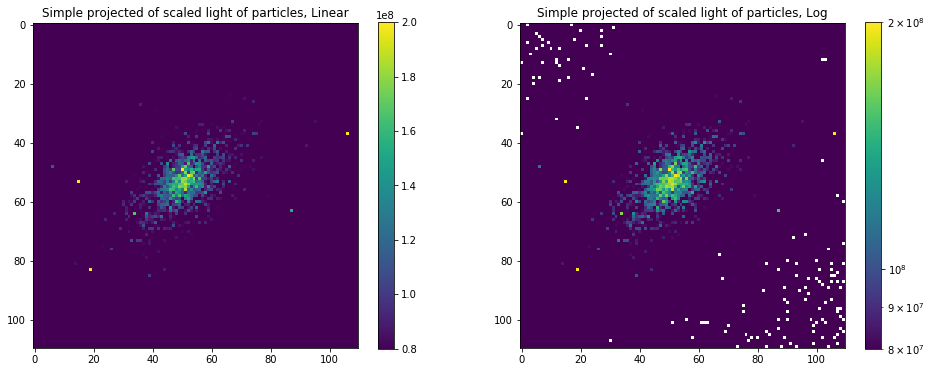

In [11]:
plt.subplot(1,2,1)
plt.imshow(scaled, vmin=8e7, vmax=2e8)
plt.colorbar()
plt.title('Simple projected of scaled light of particles, Linear')
plt.subplot(1,2,2)
plt.imshow(scaled, norm=LogNorm(), vmin=8e7, vmax=2e8)
plt.colorbar()
plt.title('Simple projected of scaled light of particles, Log')
plt.gcf().set_size_inches(16, 6)

In [12]:
config['pixel_scale'] = mocks.compute_pixel_scale(redshift,
                                                  cosmo,
                                                  config['sim_pc_pixel'])

In [13]:
apparent_ABmag = mocks.compute_apparent_mag(redshift,
                                           light,
                                           config,
                                           cosmo=cosmo)

In [14]:
apparent_ABmag

<Magnitude 6.0645056 mag(AB)>

In [15]:
config['total_mag'] = apparent_ABmag

## Creating imager:

In [16]:
imagers = imager.create_imagers()
huntsman = imagers[config['imager']]

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


### Noiseless image

In [17]:
noiseless = mocks.create_mock_galaxy_noiseless_image(config,
                                                     scaled,
                                                     huntsman,
                                                     oversampling=1)

/Users/45028222/gunagala/gunagala/psf.py:417: UserWarning: Warning: below zero values in resampled PSF. Clipping to zero.
  warn("Warning: below zero values in resampled PSF. Clipping to zero.")
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]


In [18]:
y0 = 1200
y1 = 2100
x0 = 800
x1 = 1700

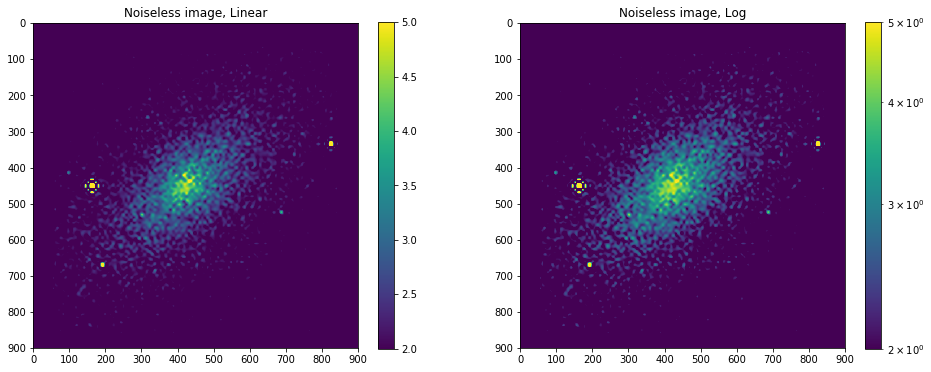

In [19]:
plt.subplot(1,2,1)
plt.imshow(noiseless[y0:y1, x0:x1], vmin=2, vmax=5)
plt.colorbar()
plt.title('Noiseless image, Linear')
plt.subplot(1,2,2)
plt.imshow(noiseless[y0:y1, x0:x1], norm=LogNorm(), vmin=2, vmax=5)
plt.colorbar()
plt.title('Noiseless image, Log')
plt.gcf().set_size_inches(16, 6)

### Convolving the noiseless image:

In [20]:
psf_data = huntsman.psf.pixellated()

In [21]:
convolved = mocks.convolve_image_psf(noiseless,
                                    psf_data,
                                    convolution_boundary='extend')

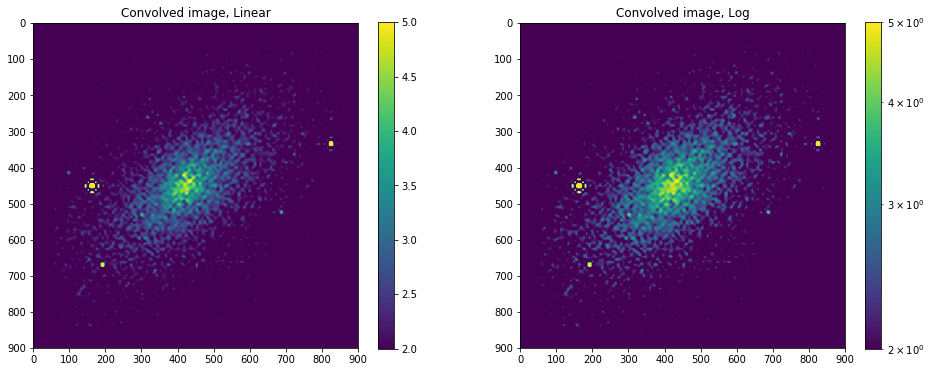

In [22]:
plt.subplot(1,2,1)
plt.imshow(convolved[y0:y1, x0:x1], vmin=2, vmax=5)
plt.colorbar()
plt.title('Convolved image, Linear')
plt.subplot(1,2,2)
plt.imshow(convolved[y0:y1, x0:x1], norm=LogNorm(), vmin=2, vmax=5)
plt.colorbar()
plt.title('Convolved image, Log')
plt.gcf().set_size_inches(16, 6)

### Creating noisy image:

The operation in the following cell has been done inside the `create_mock_galaxy_noiseless_image` once. Maybe that function should divide to two functions to prevent repeating this.

In [23]:
galaxy_psf = psf.PixellatedPSF(scaled,
                               psf_sampling=config['pixel_scale'],
                               oversampling=1)
huntsman_galaxy = imager.Imager(optic=huntsman.optic,
                        camera=huntsman.camera,
                        filters=huntsman.filters,
                        psf=galaxy_psf,
                        sky=huntsman.sky)

In [24]:
noissy = mocks.mock_image_stack(convolved, huntsman_galaxy, n_exposures=1, exptime=500 * u.s)

[2019-07-17 04:18:17.996751] INFO: logbook: Creating noisy images started.
[2019-07-17 04:18:18.975333] INFO: logbook: Creating noisy images finished.
[2019-07-17 04:18:18.975884] INFO: logbook: Combining noisy images.
[2019-07-17 04:18:19.012908] INFO: logbook: Averaging combined images.
[2019-07-17 04:18:20.009311] INFO: logbook: The stacked image is ready.
Stacking  1  images took 2.0131728649139404 to run


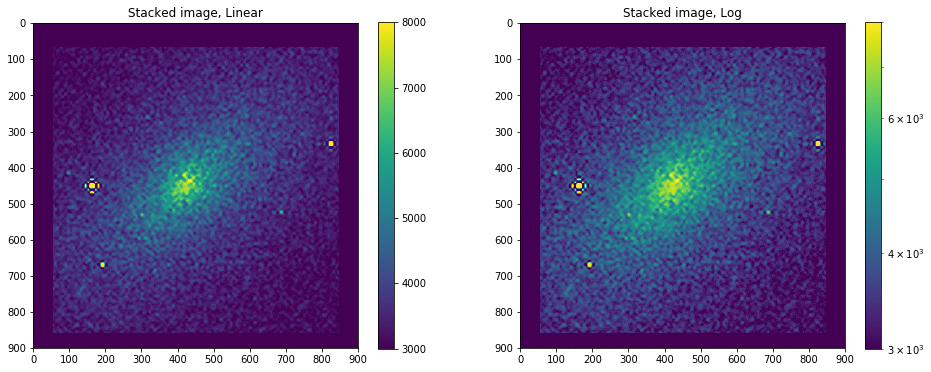

In [25]:
plt.subplot(1,2,1)
plt.imshow(noissy[y0:y1, x0:x1], vmin=3e3, vmax=8e3)
plt.colorbar()
plt.title('Stacked image, Linear')
plt.subplot(1,2,2)
plt.imshow(noissy[y0:y1, x0:x1], norm=LogNorm(), vmin=3e3, vmax=8e3)
plt.colorbar()
plt.title('Stacked image, Log')
plt.gcf().set_size_inches(16, 6)

# Creating several noissy images and stacking them.

In [26]:
stacked = mocks.mock_image_stack(convolved, huntsman_galaxy, n_exposures=100, exptime=500 * u.s)

[2019-07-17 04:18:20.670817] INFO: logbook: Creating noisy images started.
[2019-07-17 04:19:55.575912] INFO: logbook: Creating noisy images finished.
[2019-07-17 04:19:55.576465] INFO: logbook: Combining noisy images.
[2019-07-17 04:20:07.591846] INFO: logbook: Averaging combined images.
[2019-07-17 04:24:51.315576] INFO: logbook: The stacked image is ready.
Stacking  100  images took 390.6681480407715 to run


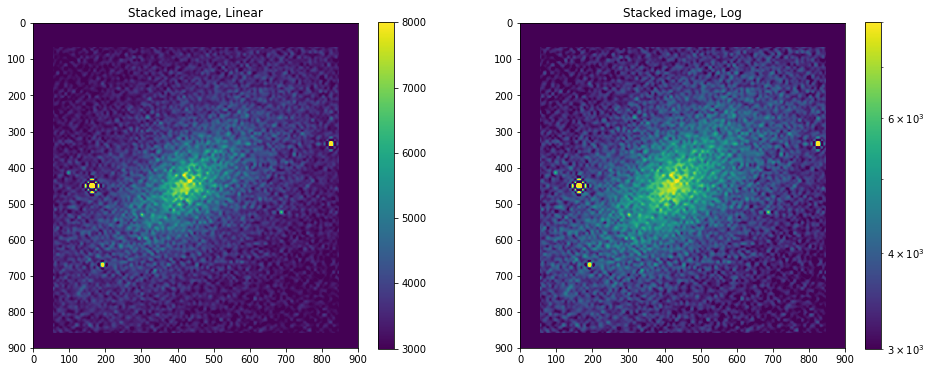

In [27]:
plt.subplot(1,2,1)
plt.imshow(stacked[y0:y1, x0:x1], vmin=3e3, vmax=8e3)
plt.colorbar()
plt.title('Stacked image, Linear')
plt.subplot(1,2,2)
plt.imshow(stacked[y0:y1, x0:x1], norm=LogNorm(), vmin=3e3, vmax=8e3)
plt.colorbar()
plt.title('Stacked image, Log')
plt.gcf().set_size_inches(16, 6)